<a href="https://colab.research.google.com/github/AlliBusa/denoising-self-study/blob/main/test_trial_deep_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries 

import numpy as np
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import os
import cv2

# %tensorflow_version 2.x
import tensorflow as tf
 
import PIL

from skimage.metrics import peak_signal_noise_ratio

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [3]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [4]:
data_dir = './BSDS500'
Xtrain = np.load(os.path.join(data_dir, 'train_noisy_array.npy'))
ytrain = np.load(os.path.join(data_dir, 'train_original_array.npy'))

Xtest = np.load(os.path.join(data_dir, 'test_noisy_array.npy'))
ytest = np.load(os.path.join(data_dir, 'test_original_array.npy'))

Xval = np.load(os.path.join(data_dir, 'val_noisy_array.npy'))
yval = np.load(os.path.join(data_dir, 'val_original_array.npy'))

# Create Model 

In [67]:
alpha = 0.5
row = 180
col = 180
numchannels = 1

# Define the inputs

input_img = tf.keras.Input(shape=(row,col, numchannels))
x =input_img
y = input_img

# Define the layers of the model
num_iterations = 4
num_CNN_layers = 10
initializer = tf.keras.initializers.GlorotNormal()  # Xavier initialization
weight_decay = 0.0001

for i in range(num_iterations):
    x_k = x
    # First layer of CNN that reshapes x
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(None, None, numchannels),
                               kernel_initializer=initializer)(x)
    for j in range(num_CNN_layers-2):
        # expand input into cnn
        x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(x)
    x = tf.keras.layers.Conv2D(numchannels, (3, 3), activation='relu', padding='same', kernel_initializer=initializer)(x)
    # implemnt (αky + xk + xk+1/2)/(αk + 1).
    denom = 1/(1+alpha)
    alpha_y = tf.multiply(alpha, y)
    # tf.print("x_k:", x_k)
    # print(x_k)
    # print(x)
    x_and_x_k = tf.add(x_k, x)
    x_and_y = tf.add(x_and_x_k, alpha_y)
    x = tf.multiply(denom, x_and_y)
    x = tf.keras.layers.Activation('relu')(x)
    # x = tf.multiply(tf.add(tf.add(tf.multiply(alpha, y), x_k), x), denom)


outputs = tf.keras.layers.Conv2D(filters=1, kernel_size=3, padding='same', activation='relu')(x)#tf.keras.layers.Dense(10, activation='softmax')(x)

# Define the model
model = tf.keras.Model(inputs=input_img, outputs=outputs)

# Print the model summary
model.summary()

# Set optimizer parameters
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, weight_decay=weight_decay)



/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 180, 180, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_79 (Conv2D)             (None, 180, 180, 64  640         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_80 (Conv2D)             (None, 180, 180, 64  36928       ['conv2d_79[0][0]']              
                                )                                                           

In [68]:
checkpoint_path = "./BSDS500/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

os.listdir(checkpoint_dir) 

['data',
 'cp.ckpt.index',
 'cp.ckpt.data-00000-of-00001',
 'cpSimple.ckpt.index',
 'cpSimple.ckpt.data-00000-of-00001',
 'checkpoint',
 'test_original_array.npy',
 'test_noisy_array.npy',
 'train_original_array.npy',
 'train_noisy_array.npy',
 'val_original_array.npy',
 'val_noisy_array.npy']

In [70]:
# Compile the model
model.compile(optimizer=adam, loss='mean_squared_error')

history = model.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                    epochs=134068,
                    batch_size=4,
                    callbacks=[cp_callback])

Epoch 1/134068
75/75 [==============================] - ETA: 0s - loss: 1091.6469
Epoch 1: saving model to ./BSDS500/cp.ckpt
75/75 [==============================] - 30s 247ms/step - loss: 1091.6469
Epoch 2/134068
75/75 [==============================] - ETA: 0s - loss: 895.0473
Epoch 2: saving model to ./BSDS500/cp.ckpt
75/75 [==============================] - 18s 240ms/step - loss: 895.0473
Epoch 3/134068
75/75 [==============================] - ETA: 0s - loss: 754.7718
Epoch 3: saving model to ./BSDS500/cp.ckpt
75/75 [==============================] - 18s 237ms/step - loss: 754.7718
Epoch 4/134068
75/75 [==============================] - ETA: 0s - loss: 626.9747
Epoch 4: saving model to ./BSDS500/cp.ckpt
75/75 [==============================] - 18s 236ms/step - loss: 626.9747
Epoch 5/134068
75/75 [==============================] - ETA: 0s - loss: 521.7938
Epoch 5: saving model to ./BSDS500/cp.ckpt
75/75 [==============================] - 18s 241ms/step - loss: 521.7938
Epoch 6/13406

KeyboardInterrupt: ignored

In [71]:
model.load_weights('./BSDS500/cp.ckpt')

In [52]:
y_predDP = model.predict(Xtest[0:10,])

1/1 [==============================] - 0s 376ms/step


# Create Reference Model

In [30]:
row = 180
col = 180
numchannels = 1

# Define input shape
inputs = tf.keras.Input(shape=(row, col, numchannels))

# Define CNN layers
x = tf.keras.layers.Conv2D(64, 3, padding='same')(inputs)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same')(x)


# Define output layer
outputs = tf.keras.layers.Conv2D(1, 3, padding='same')(x)

# Define model
modelSimple = tf.keras.Model(inputs, outputs)

# Print the model summary
modelSimple.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 180, 180, 1)]     0         
                                                                 
 conv2d_17 (Conv2D)          (None, 180, 180, 64)      640       
                                                                 
 conv2d_18 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 64)      36928     
                                                                 
 conv2d_20 (Conv2D)          (None, 180, 180, 128)     73856     
                                                                 
 conv2d_21 (Conv2D)          (None, 180, 180, 128)     147584    
                                                                 
 conv2d_22 (Conv2D)          (None, 180, 180, 64)      7379

In [31]:
modelSimple.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [8]:
checkpoint_path = "./BSDS500/cpSimple.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

os.listdir(checkpoint_dir) 

['data',
 'cp.ckpt.index',
 'cp.ckpt.data-00000-of-00001',
 'cpSimple.ckpt.index',
 'cpSimple.ckpt.data-00000-of-00001',
 'checkpoint',
 'test_original_array.npy',
 'test_noisy_array.npy',
 'train_original_array.npy',
 'train_noisy_array.npy',
 'val_original_array.npy',
 'val_noisy_array.npy']

In [34]:
historySimple = modelSimple.fit(Xtrain, ytrain, validation_data=(Xval, yval),
                    epochs=100)

Epoch 1/100
10/10 [==============================] - 5s 491ms/step - loss: 228.0144
Epoch 2/100
10/10 [==============================] - 5s 499ms/step - loss: 226.7462
Epoch 3/100
10/10 [==============================] - 5s 503ms/step - loss: 225.4765
Epoch 4/100
10/10 [==============================] - 5s 513ms/step - loss: 227.1121
Epoch 5/100
10/10 [==============================] - 5s 521ms/step - loss: 225.7503
Epoch 6/100
10/10 [==============================] - 5s 528ms/step - loss: 226.8657
Epoch 7/100
10/10 [==============================] - 5s 534ms/step - loss: 231.6977
Epoch 8/100
10/10 [==============================] - 5s 515ms/step - loss: 228.2073
Epoch 9/100
10/10 [==============================] - 5s 513ms/step - loss: 225.2243
Epoch 10/100
10/10 [==============================] - 5s 505ms/step - loss: 225.4861
Epoch 11/100
10/10 [==============================] - 5s 503ms/step - loss: 227.6391
Epoch 12/100
10/10 [==============================] - 5s 497ms/step - loss

In [35]:
y_pred = modelSimple.predict(Xtest[0:10,])

1/1 [==============================] - 2s 2s/step


# Evlaluation

In [61]:
def evaluateImage(ytest, Xtest, y_pred, ind):
  original_image = ytest[ind,]
  print(f'PSNR for the original noise image with the clean one : \n {peak_signal_noise_ratio(ytest[ind,], Xtest[ind,],data_range=original_image.max() - original_image.min())}')
  print(f'PSNR for ML model: \n {peak_signal_noise_ratio(ytest[ind,], y_pred[ind,:,:,0],data_range=original_image.max() - original_image.min())}')
  
  fig, axes = plt.subplots(1, 3, figsize=(12, 4))

  axes[0].imshow(y_pred[ind,:,:,0], cmap='gray')
  axes[0].set_title("ML cleaned Image")

  axes[1].imshow(Xtest[ind,:,:], cmap='gray')
  axes[1].set_title("Original Noist Image")

  axes[2].imshow(original_image, cmap='gray')
  axes[2].set_title("Original Image")

  plt.show()



In [36]:
original_image = ytest[0,:,:]

In [37]:
peak_signal_noise_ratio(ytest[0,], Xtest[0,],data_range=original_image.max() - original_image.min())

20.398026585244196

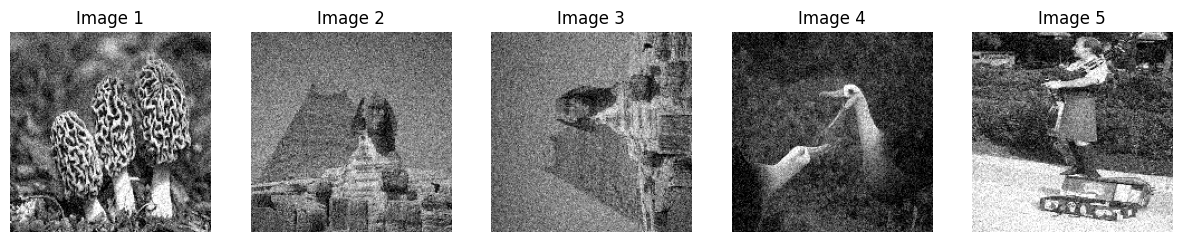

<Figure size 640x480 with 0 Axes>

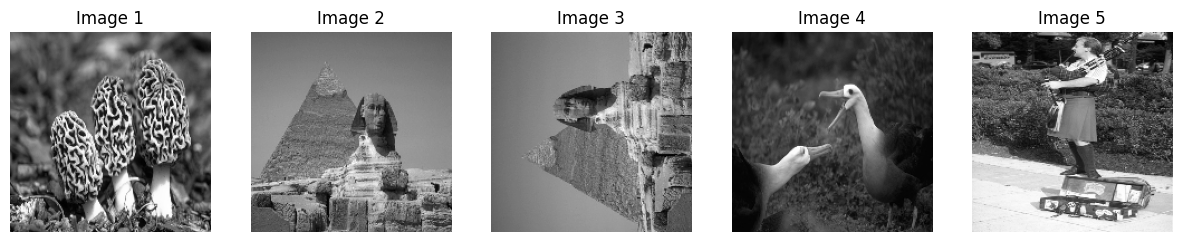

<Figure size 640x480 with 0 Axes>

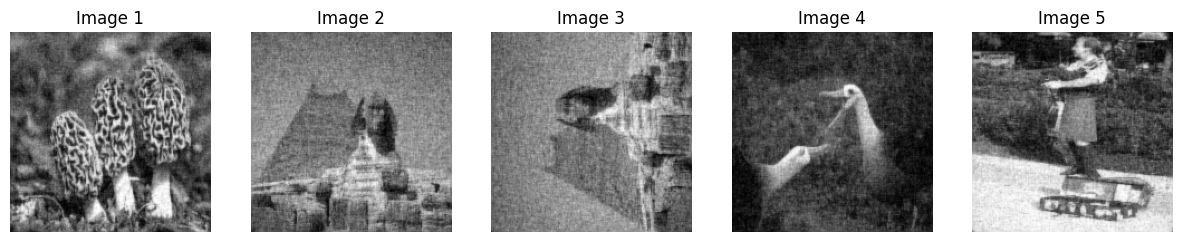

<Figure size 640x480 with 0 Axes>

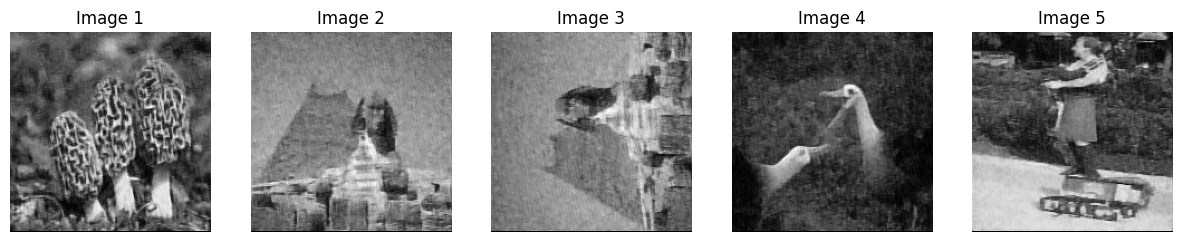

<Figure size 640x480 with 0 Axes>

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
plt.figure()
for i in range(5):
    # print(np.shape(ytest[i,]))
    axes[i].imshow(Xtest[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
plt.figure()
for i in range(5):
    # print(np.shape(ytest[i,]))
    axes[i].imshow(ytest[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
plt.figure()
for i in range(5):
    # print(np.shape(ytest[i,]))
    axes[i].imshow(y_pred[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15,4))
plt.figure()
for i in range(5):
    # print(np.shape(ytest[i,]))
    axes[i].imshow(y_predDP[i,], cmap='gray')
    axes[i].set_title(f'Image {i+1}')
    axes[i].axis('off')
plt.show()

PSNR for the original noise image with the clean one : 
 20.398026585244196
PSNR for ML model: 
 21.99777739722572


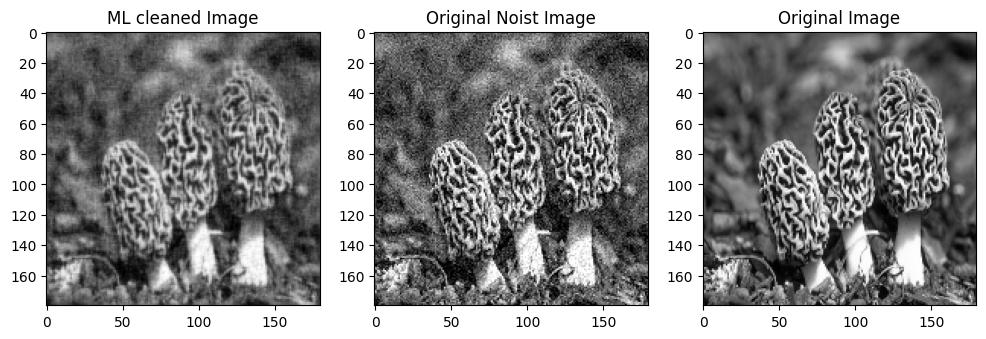

In [62]:
evaluateImage(ytest, Xtest, y_pred, 0)

PSNR for the original noise image with the clean one : 
 20.30219589051316
PSNR for ML model: 
 25.308053663907355


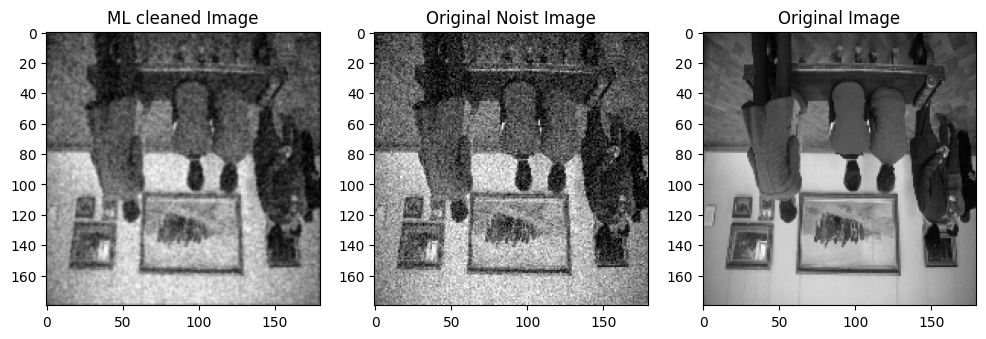

In [83]:
evaluateImage(ytest, Xtest, yPredict, 9)

In [72]:
yPredict = model.predict(Xtest)

1/1 [==============================] - 0s 353ms/step


In [78]:
np.shape(yval)

(0,)

In [73]:
# randomly pick 68 indices
indices = np.random.choice(len(ytest), size=68, replace=False)

# initialize a list to store the PSNR values
psnrs = []

# iterate over the selected indices and compute PSNR for each image
for ind in indices:
    psnr = peak_signal_noise_ratio(ytest[ind], yPredict[ind])
    psnrs.append(psnr)

# compute the average PSNR
avg_psnr = np.mean(psnrs)

ValueError: ignored